# Simple demonstration of discrete Markov processes

Toni Giorgino (IBF-CNR)

You should run this notebook in an R instance or Google Colab.
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giorginolab/Markov-Tutorial-Data/blob/main/MarkovFromScratch.ipynb)



# Introduction

This file shows the basic concept of Markov State Model (MSM)
building "from the ground up", i.e. without using one
of the specialized libraries. It is implemented in the
R language, and can be trivially translated into
any other supporting linear algebra functions (notably,
eigendecomposition).

We first load the trajectory. It was
constructed as the location of a walker
moving stochastically in a 1D double-well
potential. There are 100,000 trajectory steps.
The motion takes place in a finite, 100-states 
space corresponding to the X positions (in other words,
the trajectory has already been converted into microstates).

(This is the same trajectory distributed
with PyEmma's `load_2well_discrete` function.
The `d10` version has the same number of points,
but decimated by a factor of 10 (so 10 times longer). For
PyEmma see http://emma-project.org and the 
corresponding paper (see references at the bottom).


In [1]:
get.url.gz <- function(u) {
  textConnection(readLines(gzcon(url(u))))
}


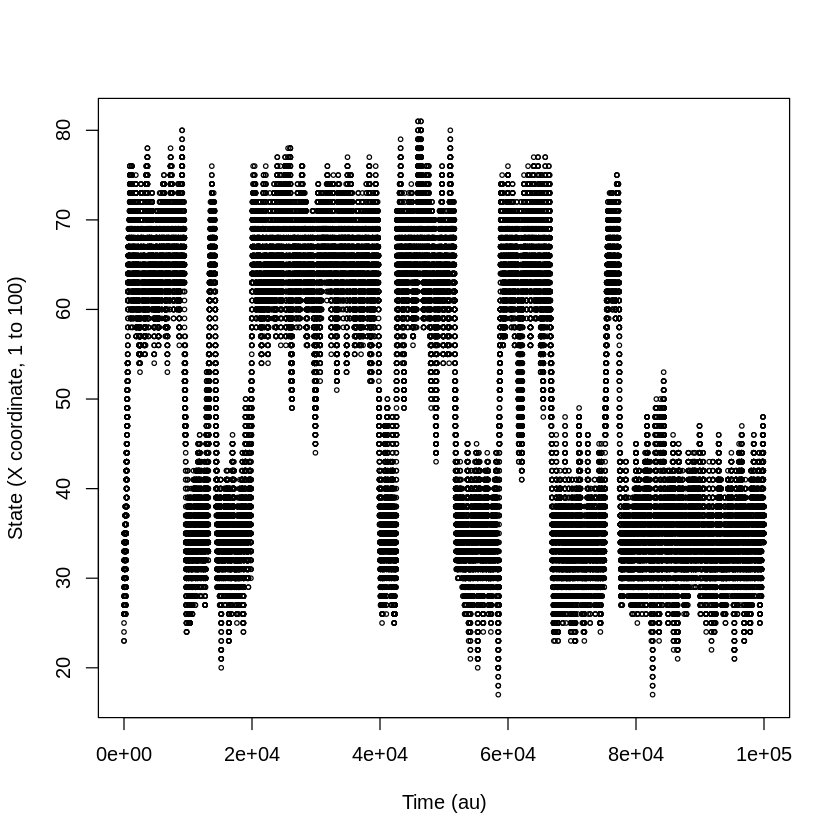

In [2]:
d1<-read.csv(get.url.gz("https://github.com/giorginolab/Markov-Tutorial-Data/raw/main/data/data1.csv.gz"), head=F)$V1
d10<-read.csv(get.url.gz("https://github.com/giorginolab/Markov-Tutorial-Data/raw/main/data/data10.csv.gz"), head=F)$V1

d<-d1       # Work on d1

plot(d,type="p",cex=.5,
     ylab="State (X coordinate, 1 to 100)",
     xlab="Time (au)")


## State probabilities and Boltzmann inversion

Without considering the kinetics, and
assuming the sampled trajectory was 
sufficiently long (sufficient sampling
of the equilibrium distribution)
we can try to compute the underlying
free-energy potential by the probability
distribution of the states, i.e. how many
times (= fraction of the total time 
spent) each was visited.

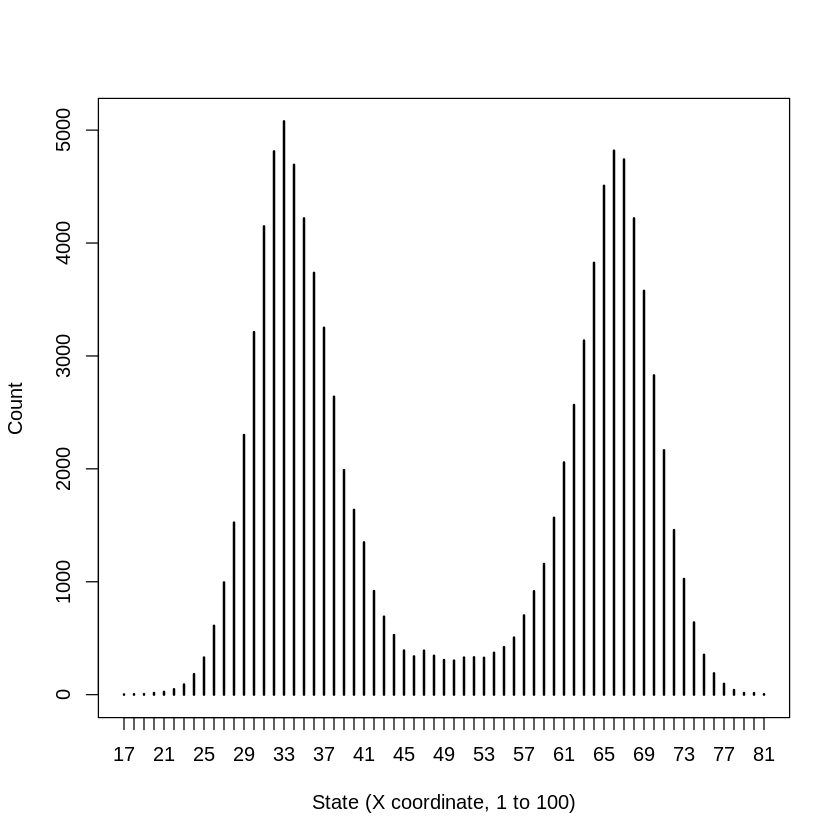

In [3]:
h<-table(d)
plot(h, xlab="State (X coordinate, 1 to 100)",
     ylab = "Count")


Boltzmann inversion (note that $k_BT=1$) returns
the $\Delta G$ (up to an irrelevant additive constant).

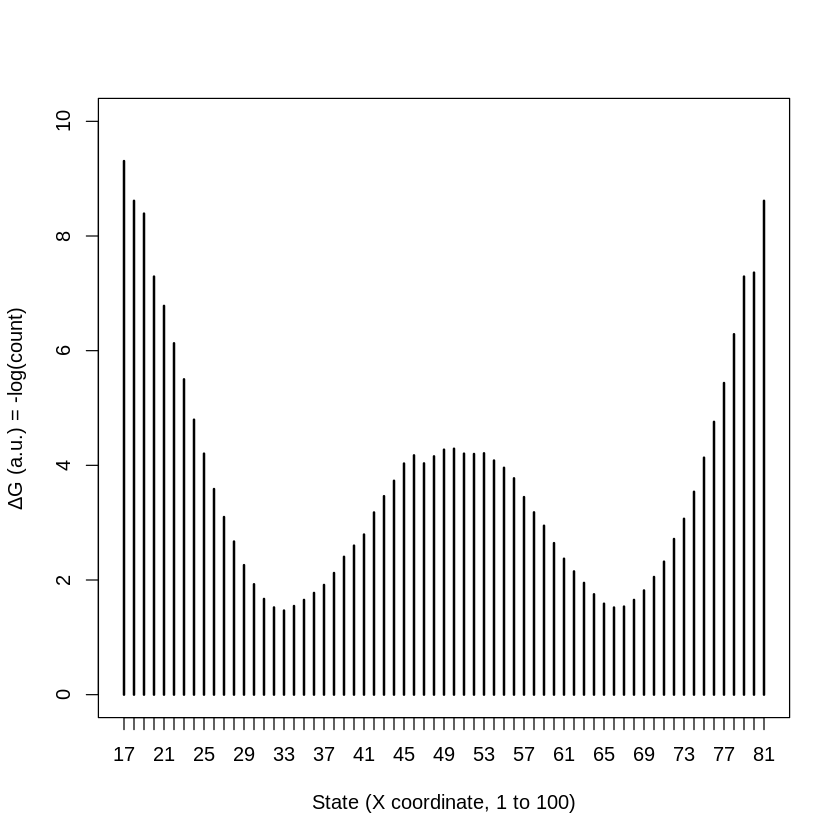

In [4]:
plot(10-log(h),ylim=c(0,10),
     xlab="State (X coordinate, 1 to 100)",
     ylab="ΔG (a.u.) = -log(count)"
     )


# Markov state modeling

## Construction of the transition matrix

We compute how many times each state to state ($i\to j$)
transition has occurred *after a lag time of $\tau$*.


In [5]:
tau <- 10
lab <- sort(unique(d))
TT <- table( head(d,-tau),
            tail(d,-tau))

The transition probability matrix is large (~ 100x100)
but we may visualize it as an image

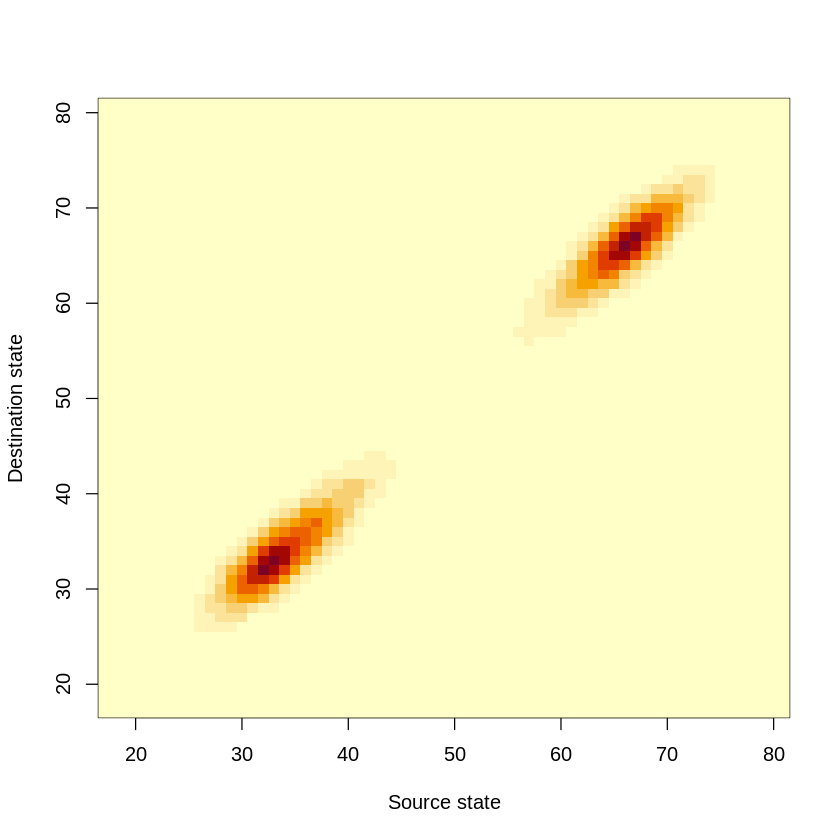

In [6]:
image(lab,lab,TT,
      xlab="Source state",ylab="Destination state")


Of course, transitions around the two
free energy wells are sampled more often, so they show
up clearly.

We divide each row of the transition
count  matrix so that they
sum to unity. We thus obtain the
transition *probability* matrix. Note
that, for simplicity, this is a simplified
treatment in the following respects: (1) 
one should take care
of reversibility, (2) use a maximum-likelihood
estimator, and (3) deal properly with zero counts
(which cause singularities).

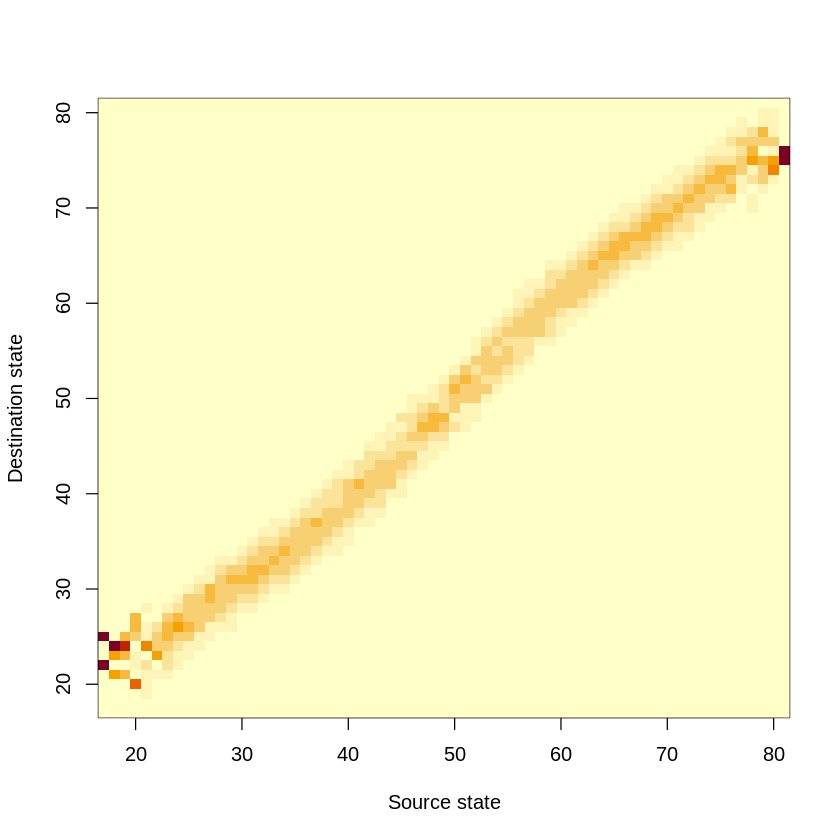

In [7]:

sum1 <- function(x) (x/sum(x))
P <- t(apply(TT,2,sum1 ))
image(lab,lab,P,
      xlab="Source state",ylab="Destination state")


## Eigenvalues

From the transition probability matrix **at lag $\tau$**
we compute the *left*  eigenvectors and eigenvalues.

The eigenvalues correspond to the relaxation 
rates towards equilibrium. The largest eigenvalue
is unity, corresponding to the stationary state.

Eigenvalues describe the negative *exponential* relaxation time scales, in units of $\tau$. Therefore, 
the should be converted to "normal" time units
throught the *implied time scales* (ITS) equation, i.e.:

$$\tau_i = -\tau/\log(\mu_i)$$

where $\tau_i$ is the $i$-th implied time scale and $\mu_i$
the corresponding eigenvalue.


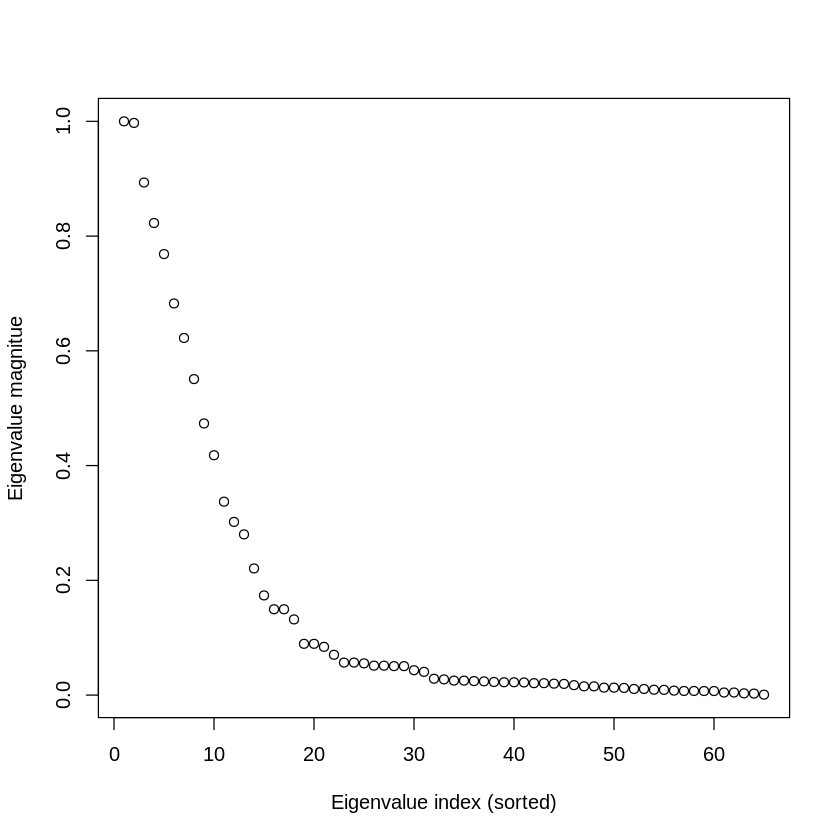

In [9]:
ei <- eigen(t(P))
eva <- sort(abs(ei$values),decreasing = T)
eve <- ei$vectors

taus <- -tau/log(eva[-1])

plot(eva,ylab="Eigenvalue magnitue",xlab="Eigenvalue index (sorted)")


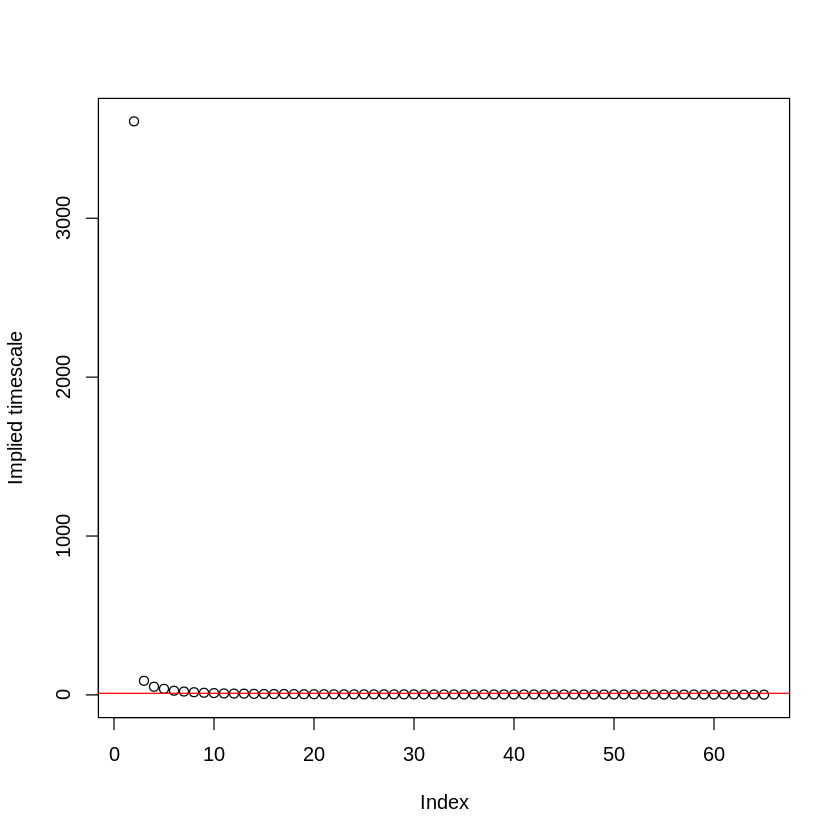

In [10]:

plot(c(NA,taus),ylab="Implied timescale")
abline(h=tau,col="red")


Given the  spread of timescales is usually
large, we plot them in logarithmic scale.

Kinetics faster than $\tau$ can **not** be 
resolved by construction of the transition
matrix.

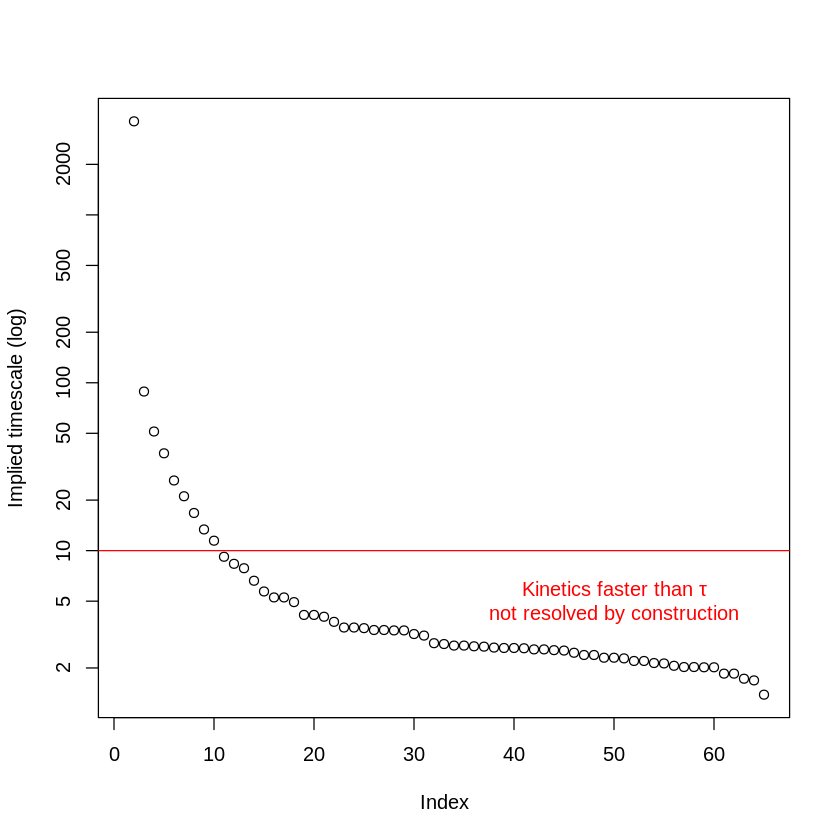

In [11]:
plot(c(NA,taus),ylab="Implied timescale (log)",log="y")
abline(h=tau,col="red")
text(50,5,"Kinetics faster than τ\nnot resolved by construction",
     col="red")


## Eigenvectors


Eigenvectors matching a given eigenvalue describe 
the "contribution" of each state to that relaxation
mode.  The eigenvector of the unitary eigenvalue
is the stationary distribution, i.e. the equilibrium
(after normalizing it so it sums to 1).
Its Boltzmann inversion provides the free energy landscape.


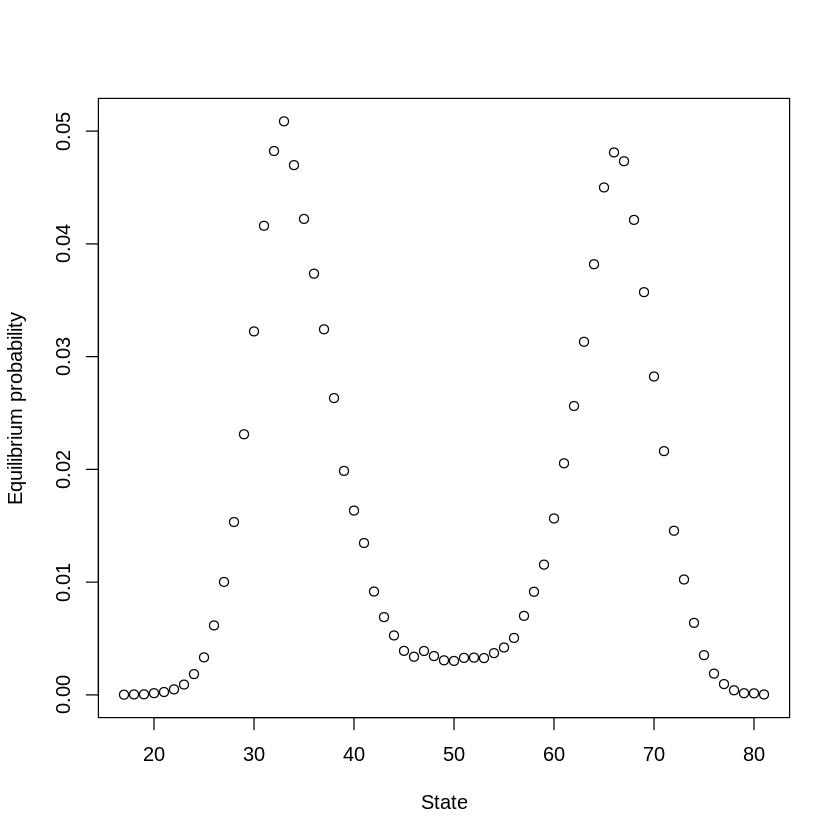

In [12]:

ev0 <- Re(eve[,1])
ev0dg <- -log(ev0)+max(log(ev0))-2

plot(lab,sum1(ev0),
     xlab="State",ylab="Equilibrium probability")


The other eigenvector describe the 
"wave" of the relaxation (at the matching
implied timescale).


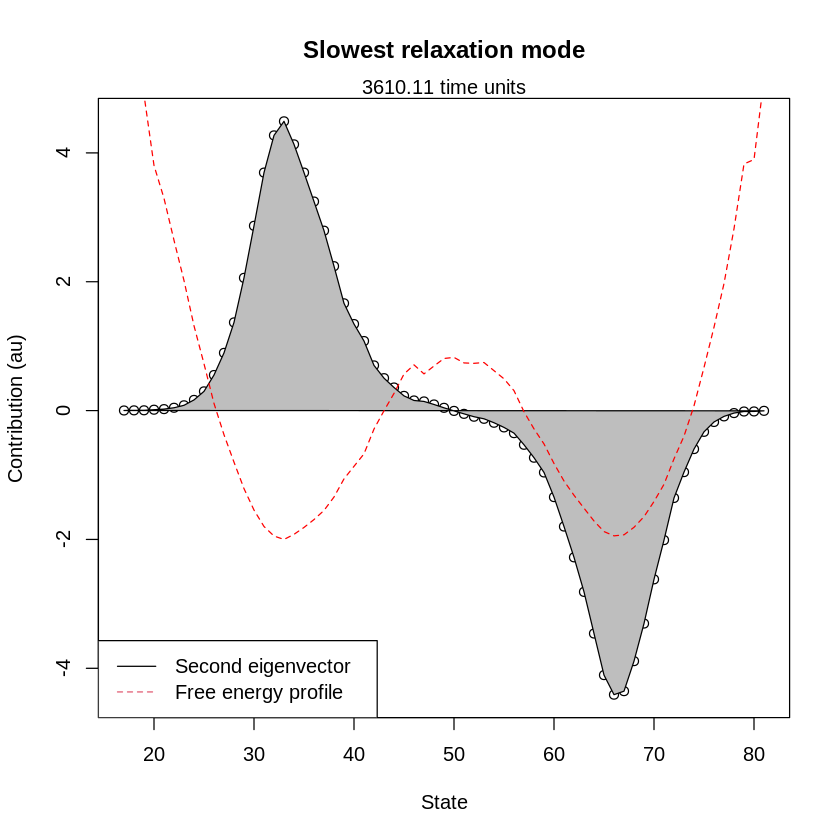

In [15]:

ev1 <- 2*scale(Re(eve[,2]))
plot(lab,ev1,
     xlab="State",ylab="Contribution (au)",
     main="Slowest relaxation mode")
polygon(lab,ev1,col="gray")
#lines(lab,sum1(ev0)*20,col="red",lty=2)
lines(lab,ev0dg,col="red",lty=2)
mtext(sprintf("%.2f time units",taus[1]),3)
legend("bottomleft",col=1:2,lty=1:2,
       c("Second eigenvector",
         "Free energy profile"))



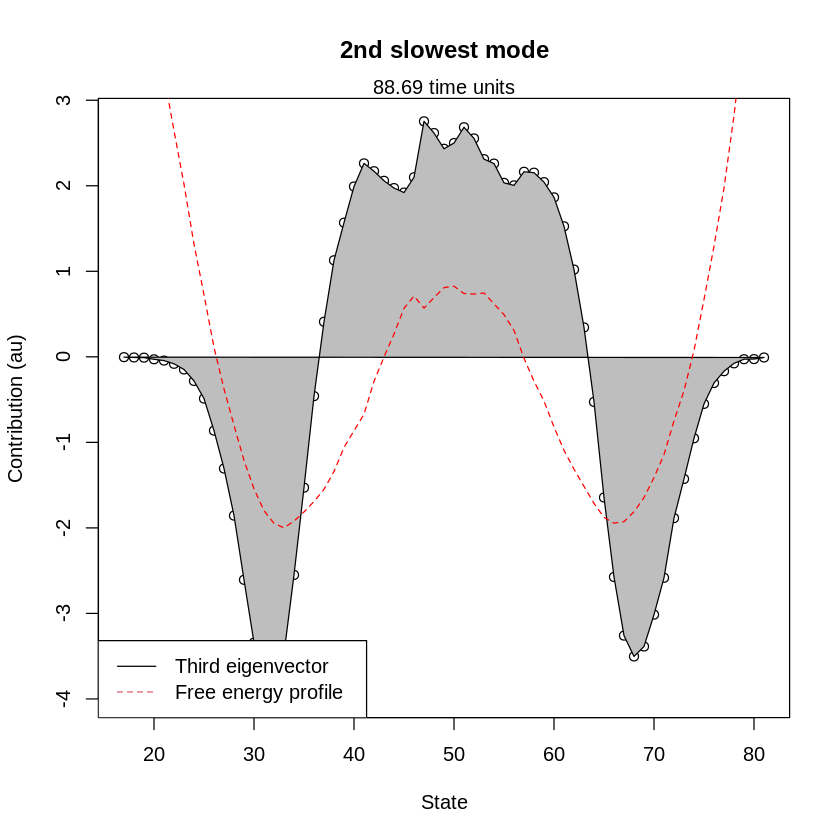

In [14]:

ev2 <- 2*scale(Re(eve[,3]))
plot(lab,ev2,
     xlab="State",ylab="Contribution (au)",
     main="2nd slowest mode")
polygon(lab,ev2,col="gray")
lines(lab,ev0dg,col="red",lty=2)
legend("bottomleft",col=1:2,lty=1:2,
       c("Third eigenvector",
         "Free energy profile"))
mtext(sprintf("%.2f time units",taus[2]),3)


The shape of  the eigenvectors suggests
a clustering into coarser-grained macrostates.
This constitutes the gist of 
the Perron-cluster analysis (PCCA+).



## Choice of the lag time

Remember that the transition matrix 
was, by construction,    **a function of $\tau$**.
Therefore, the whole eigenvector analysis 
shown before should be repeated at increasing
values of $\tau$ to study its sensitivity.

We pick the smallest $\tau$ such that the implied
timescales are effectively "flat". Again,
the literature provides much more sophisticated
statistical tests
on the Markovianity assumption (e.g. Chapman-Kolmogorov).
See e.g. [PyEmma's Model selection and validation](http://www.emma-project.org/latest/generated/model_selection_validation.html) tutorial.


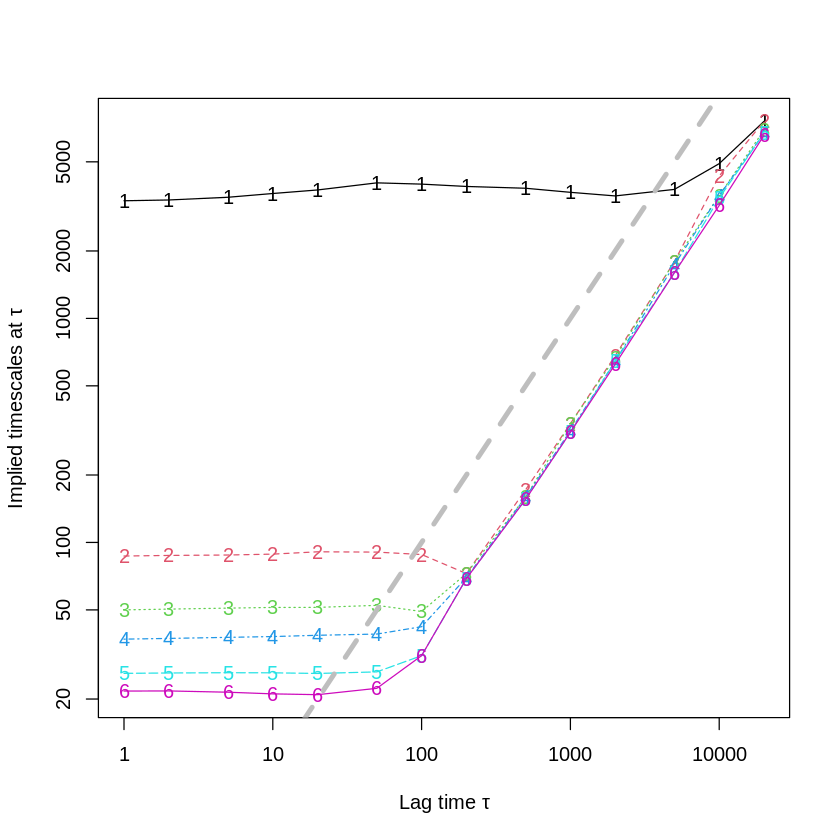

In [16]:

evanalysis <- function(tau) {
    TT <- table( head(d,-tau),
            tail(d,-tau))
    P <- t(apply(TT,2,sum1 ))
    ei <- eigen(t(P))
    eva <- sort(abs(ei$values),decreasing = T)
    eve <- ei$vectors
    taus <- -tau/log(eva[-1])
    list(eva=eva,eve=eve,taus=taus)
}

lag_list <- c(1,2,5,10,20,50,100,200,500,
              1000,2000,5000,10000,20000)

ntaus <- 6 # Consider this many eigenvectors
tau_matrix <- matrix(0,length(lag_list),ntaus)
li <- 1
for(lag in lag_list) {
    etaus <- evanalysis(lag)$taus
    tau_matrix[li,] <- head(etaus,ntaus)
    li <- li+1
}

matplot(lag_list,tau_matrix,type="o",log="xy",
        xlab="Lag time τ",ylab="Implied timescales at τ")
lines(1:10000,1:10000,lwd=4,col="grey",lty=2)


So, in this specific case, the implied timescales
are independent of $\tau$. This is a lucky situation
due to the fact that it is **truly** a two-state
system, with one finely-discretized dimension,
and (literally) no "orthogonal" degrees of freedom. 

## Macrostates

In practice, as soon as the system gets more complicated,
one faces other situations. For example, the 
large separation of timescales may motivate
us to discretize the system into two macrostates.
In practice, one will lump many states into one,
and recompute the transition matrices, eigenvectors,
etc. 

Macrostates should be defined *kinetically*, i.e., 
they should hold configurations in interchanging
relatively rapidly within them, separated by barriers.
This decomposition may or may not correspond to
distances in a space defined on the basis of structures.

The zeros of the eigenvectors (see above) are a 
good starting point for defining kinetic basin boundaries.
This can be done by inspection (in a simple
case like this) or automatically (by the PCCA+ algorithm).
Let's see two possible choices.


![](https://raw.githubusercontent.com/giorginolab/Markov-Tutorial-Data/main/img/fig_selval_ab.png)

The "good discretization" is sufficiently 
fine so that the Markovian assumption holds,
at least approximately, especially at larger $\tau$: 
if we construct the transition matrix looking
at a sufficiently far future, the system will
have lost memory of the past. Also, the discretization
is finer where the dynamics is slower. This also 
helps. 

In the "good discretization" case, it makes perfect 
sense to compute the mean first passage
time (MFPT) between the leftmost and rightmost 
states. In a biomolecular system, that would be 
the kinetics.

In the "bad discretization" case, the barrier is
embedded in one of the states. This generates 
a "long term memory" effect:   the rightmost state
could actually be short-lived (if we are on the left
of the barrier) or long-lived (if we are on its right).
These two cases are convoluted in the same state,
so that the state information itself is not sufficient 
any longer to predict the "future" of the system.

The implied timescale plots reflect the two cases.
Note the lack of convergence in the "bad" case (no plateau).

![](https://raw.githubusercontent.com/giorginolab/Markov-Tutorial-Data/main/img/its.png)


# Further study and play

This worksheet is based on [PyEmma's Model selection and validation](http://www.emma-project.org/latest/generated/model_selection_validation.html) tutorial. The  tutorial uses a decimated version of
the dataset used here (here loaded in the `d10`
variable). What happens if you repeat
the  analysis of this document on the decimated
dataset? Can you explain the differences?

You are encouraged to check the following software packages and the corresponding tutorials and datasets:

 * [Deeptime](https://deeptime-ml.github.io/latest/index.html)
 * [PyEmma](http://www.emma-project.org)
 * [HTMD](https://www.htmd.org/)
 * [MSMBuilder](http://msmbuilder.org/)
 

# Relevant papers (a selection)

1. Scherer MK, Trendelkamp-Schroer B, Paul F, Pérez-Hernández G, Hoffmann M, Plattner N, et al. PyEMMA 2: A Software Package for Estimation, Validation, and Analysis of Markov Models. J Chem Theory Comput. 2015 Nov 10;11(11):5525–42. 
1. Plattner N, Doerr S, De Fabritiis G, Noé F. Complete protein–protein association kinetics in atomic detail revealed by molecular dynamics simulations and Markov modelling. Nat Chem [Internet]. 2017 Jun 5 [cited 2017 Jun 9];advance online publication. Available from: http://www.nature.com/nchem/journal/vaop/ncurrent/full/nchem.2785.html?WT.feed_name=subjects_molecular-biology
2. Chodera JD, Noé F. Markov state models of biomolecular conformational dynamics. Current Opinion in Structural Biology. 2014 Apr 1;25(Supplement C):135–44. 
3. Noé F, Fischer S. Transition networks for modeling the kinetics of conformational change in macromolecules. Current Opinion in Structural Biology. 2008 Apr 1;18(2):154–62. 
1. Pérez-Hernández G, Paul F, Giorgino T, De Fabritiis G, Noé F. Identification of slow molecular order parameters for Markov model construction. The Journal of Chemical Physics. 2013 Jul 3;139(1):015102-015102-13. 
1. Buch I, Giorgino T, De Fabritiis G. Complete reconstruction of an enzyme-inhibitor binding process by molecular dynamics simulations. Proc Natl Acad Sci USA. 2011 Jun 6;108(25):10184–9. 

